# End-to-end Machine Learning project in Python <br />  <hr style="border:4.5px solid #108999"> </hr>



___

<a href='https://github.com/kevinprinsloo/My_Machine_Learning_Notebooks/tree/master/Full_End_to_End_ML_Project_House_Prices'><img src='https://github.com/kevinprinsloo/My_Machine_Learning_Notebooks/tree/master/Full_End_to_End_ML_Project_House_Prices/images/Cali_house.jpg'/></a>
___
<center><em>Copyright by MITc.</em></center>
<center><em>For more information, contact at <a href='https://twitter.com/KevinD_P'>@KevinD_P</a></em></center>

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import pandas as pd
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Other plotting functions
import seaborn as sns

### Optional: Where to save the output figures

In [6]:
PROJECT_ROOT_DIR = "C:/Users/kevin/OneDrive/Upskill_Puthon_DS/Github_oneDrive/End_to_end_ML_project/"
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the data

This function fetches the latest version of the data. This automation is optimal if the source data is changing regularly or you need to load it onto a different PC. But you could install is manually and unzip the .tgz file.

In [7]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/kevinprinsloo/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Now we call `fetch_housing_data()` this creates a **dataset/housing** directory in your workspace, downloads the `housing.tgz` file, and extracts the `housing.csv` file from it in this directory.

In [8]:
fetch_housing_data()

Now we load the data using 'pandas'. We write a function here to load the data. The function returns a `pandas` DataFrame object containing all the data.

In [9]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

Now we have a quick look at the data

In [10]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- There are 20,640 instances of the data, which indicates that it is somewhat smaller than standard Machine Learning datasets. But this is a good introductory point. 
- We will also notice that **total_bedrooms** has missing data.

### Structure of non-numerical features

First, inspect the **non-numerical** entries.

In [16]:
# Display non-numerical features
housing.select_dtypes(exclude="number").head()

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY


We can see that only `ocean_proximity` column has categorical values, i.e., non-numerical features.

In [17]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Using the `.describe()` function we can also investigate how many unique values each non-numerical feature has and with which frequency the most prominent value is present.

In [18]:
housing.describe(exclude='number')

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


> When you pass exclude="number" to df.describe, pandas excludes all the columns in the dataframe whose data types are subclasses of numpy.number 

> only the non-numeric columns remain in the dataframe. This is useful when you want to see only the categorical variables' summary


### Structure of numerical features

Next, take a closer look at the numerical features. More precisely, investigate how many unique values each of these feature has. This process will give some insights about the number of **binary** (2 unique values), **ordinal** (3 to ~10 unique values) and **continuous** (more than 10 unique values) features in the dataset.

In [12]:
# For each numerical feature compute number of unique entries
unique_values = housing.select_dtypes(include='number').nunique().sort_values()

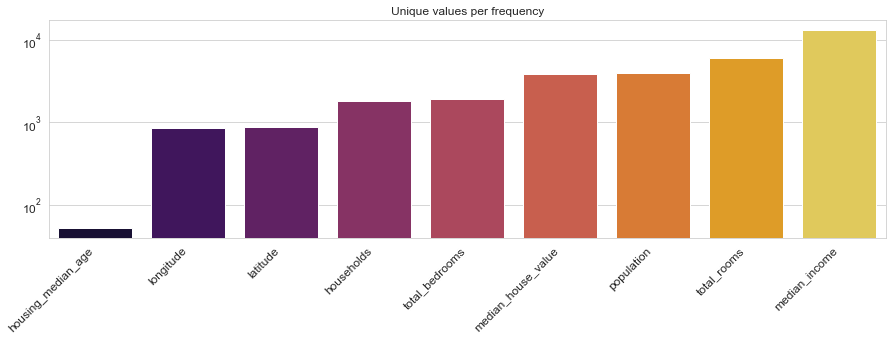

In [11]:
plt.figure(figsize=(15, 4))
sns.set_style('whitegrid')

g = sns.barplot(x=unique_values.index, y=unique_values, palette='inferno')
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('Unique values per frequency')
plt.show()

At the end of this first investigation, we should have a better understanding of the general structure of our dataset. Number of samples and features, what kind of data type each feature has, and how many of them are binary, ordinal, categorical or continuous. For an alternative way to get such kind of information you could also use `df_X.info()` or `df_X.describe()`.

In [21]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


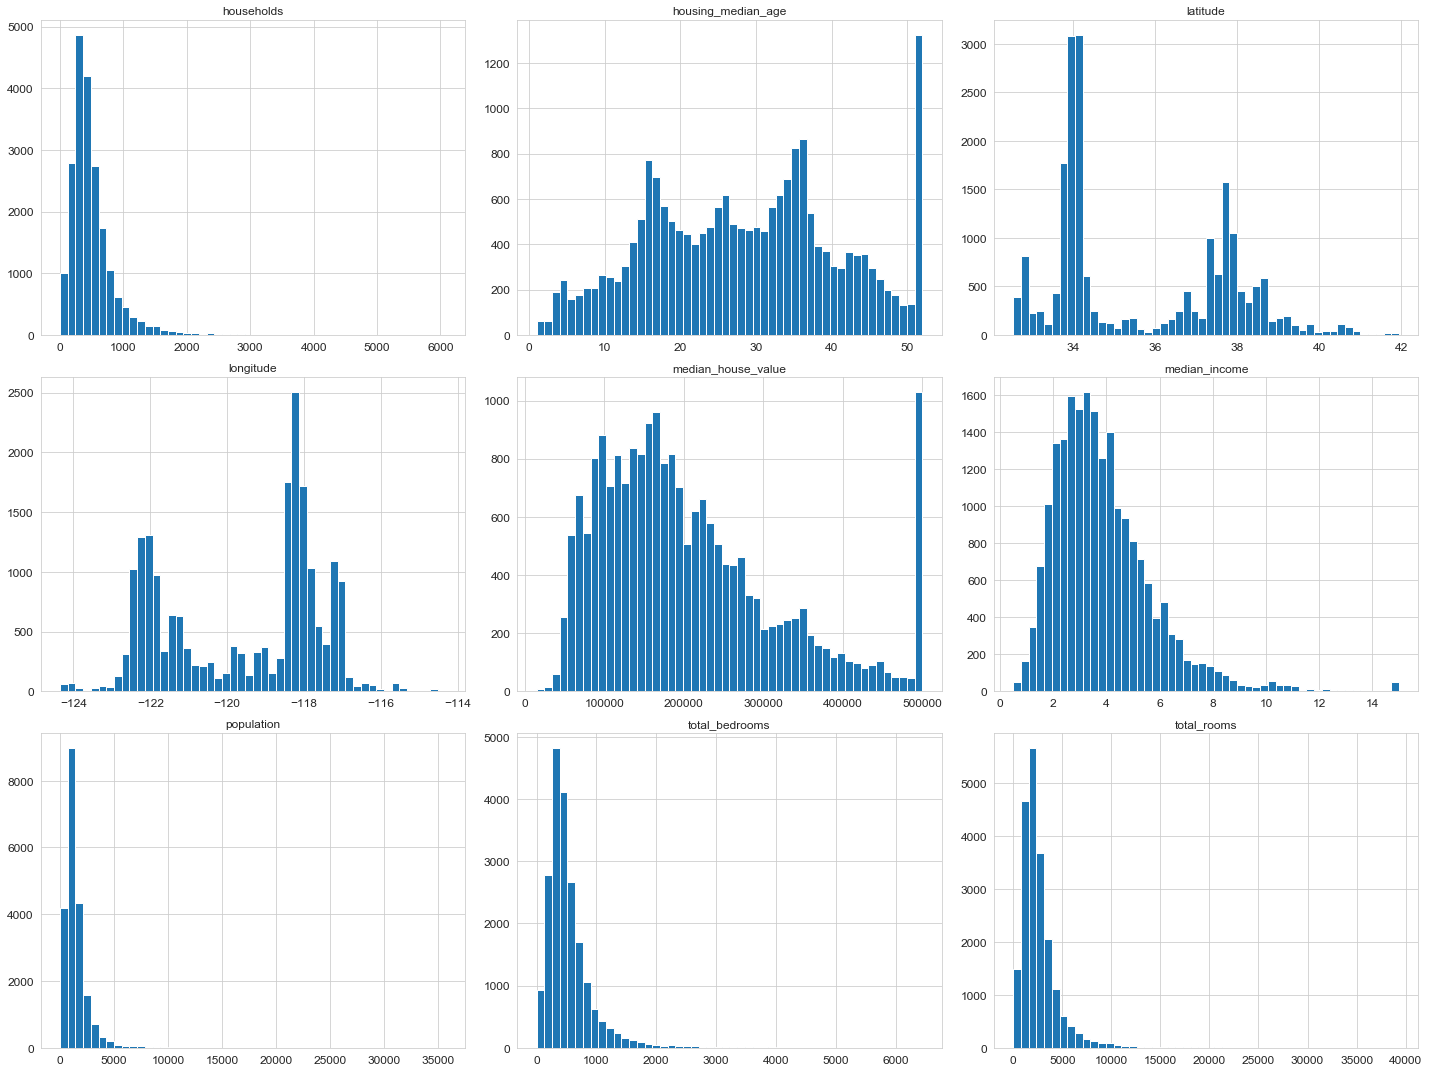

In [24]:
housing.hist(bins=50, figsize=(20,15))
save_fig('attribute_histogram_plots')

- Looking at the data you'll notice that `median_income` is not represented in US dollars (USD).
- Information given prior to working with the data mentions that the data collection team scalded and capped the data at 15 (exactly, 15.0001) for higher median income and at 0.5 (exactly, 0.4999) for lower median incomes.
- The numbers represent tens of thousands of dollars i.e, 3 represents $30,000.
- median `housing_median_age` and `median_housing_value` were also capped. The latter is concerning as it is our target attribute (i.e, our labels for our model). How to deal with this depends on what the project leads wants. Check with the Project lead and see if this cap is going to be an issue. If it is an issue and they requested precise predictions even beyond $500,000 then you have two options.
    1. Go back to the data collection team and collect proper labels for those which were capped
    2. Remove them from training and test set
- These attributes have very different scale so you'll need to normalize them (but it is not within the scope of this notebook)
- Histograms are skewed further right of the median. Some ML algorithms might struggle to detect patterns. Later we will transform these attributes to have a more cell-shaped distribution


## Create a Test Set

Create a **holdout test set**

The code below is only for illustrative purposes - use rather `Sklearn has train_test_split()`

In [13]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [14]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

Then you can use the funtion like this...

In [15]:
train_set, test_set = split_train_test(housing, 0.2)

In [16]:
len(train_set)

16512

In [17]:
len(test_set)

4128

* Make sure to do some research on Machine Learning overview videos on supervised learning to understand why we do this step
* Also vital when comparing across different machine learning algorithms that the train-test split ration remains the same
* It's very important that is the data is sorted that you cannot take the top 30% for training. Instead we want to make sure we shuffle the data to get a random sample of the dataset, then grab the 30% and 70% for the split.
* This is why we have the `random_state`
* The random seed is set to 42 here which is an arbitrary value. Often I use 42 as it's a reference to Hitchhiker's guide to the Galaxy.
* This value become important when you would like to compare the performance of multiple algorithms. Then this value should remain the same


In [17]:
from sklearn.model_selection import train_test_split

By general convention people use 30% of the data to be left out for the test set, but in reality there are more complex ways we can make this selection. here we will use a 20% of the data to be left out for the test set.

random sate:
https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn

In [18]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [20]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<AxesSubplot:>

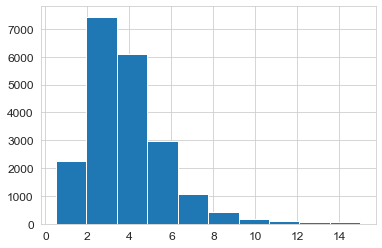

In [21]:
housing['median_income'].hist()

- You might predict that `median_income` is an important attribute to predict housing prices.
- In the case it is important to ensure that your `test_set` is representative of the various categories of `income` in the whole dataset.
- However, `median_income` is a continuous numerical attribute, we'll need to create income category attribute.
- To do this we'll first have a look at the `median_income` attribute. here we that most values are clustered around 1.5 - 6 (i.e., $15k - $60k), while some are far beyond 6.
- It's vital that we ensure that there are sufficient instances of each stratum, or our estimate of a particular stratum's importance is biased (i.e., each stratum should be equally distributed and there should be enough instances of each stratum)

The following code uses `pd.cut` function to create an income category attribute - `income_cat` - with 5 categories (1-5): category 1 ranges from 0 to 1.5 (i.e., < %15K), category 2 ranges from 1.5 to 3, and so on ...

In [19]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [20]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

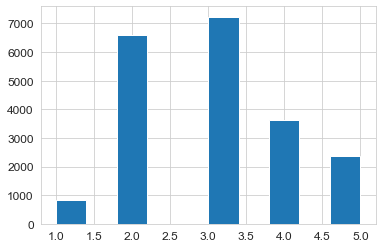

In [24]:
housing["income_cat"].hist()

Now we are ready to do stratified sampling based on the income category. For this we use Scikit-Learn's `StratifiedShuffleSplit` class:

Stratified ShuffleSplit cross-validator

Provides train/test indices to split data in train/test sets.

This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

Note: like the ShuffleSplit strategy, stratified random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.



In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

In [22]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Now we'll see if this stratified split worked. We'll start by looking at the income category proportions in thew test set:

In [23]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Using similar code, we can measure the income category proportions for the entire dataset. The output below shows this comparison between the income category proportions and the full dataset overall - i.e., the comparison between the `test_set` generated with stratified sampling and the `strat_test_set` generated using purely random sampling.

As we see below `strat_test_set` has income proportions almost identical to those of the full dataset, whereas the `test_set` generated using purely random sampling is skewed.

In [24]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)

In [25]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [26]:
income_cat_proportions(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [27]:
compare_props = pd.DataFrame({
    'Overall': income_cat_proportions(housing),
    'Stratified': income_cat_proportions(strat_test_set),
    'Random': income_cat_proportions(test_set),
}).sort_index()

In [32]:
compare_props

,Overall,Stratified,Random
1,0.039826,0.039971,0.040213
2,0.318847,0.318798,0.324370
3,0.350581,0.350533,0.358527
4,0.176308,0.176357,0.167393
5,0.114438,0.114341,0.109496


In [28]:
compare_props['Rand. %error'] = 100 * compare_props['Random'] / compare_props['Overall'] - 100
compare_props['Strat. %error'] = 100 * compare_props['Stratified'] / compare_props['Overall'] - 100 

In [34]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


Now we want to remove `income_cat` attribute from the dataframe so it's back to the original state.

In [29]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In the previous section we've spent a lot of time ensuing the test set generation is accurate. Often this is neglected but it rather crucial part of an ML project. Many of these steps are useful when we look at **cross-validation** later on


# Data exploration and Visualisation to gain insights

Next, we dig a bit deeper into the dataset. Here we'll focus only on the training set `train_set`. Often ML datasets are large and it might be worth exploring the training data only a smaller subset of the training set data to enable quicker exploration and manipulations. The current dataset is somewhat smaller than usual, so we'll just be working with the full set.

> We'll create a copy so we can play around with, without any consequences on the training set:

In [30]:
housing = strat_train_set.copy()

### Visualse Geiographical data

The data consists of longitude and latitude information, the affords us the ability to use a scatterplot to visualize the data

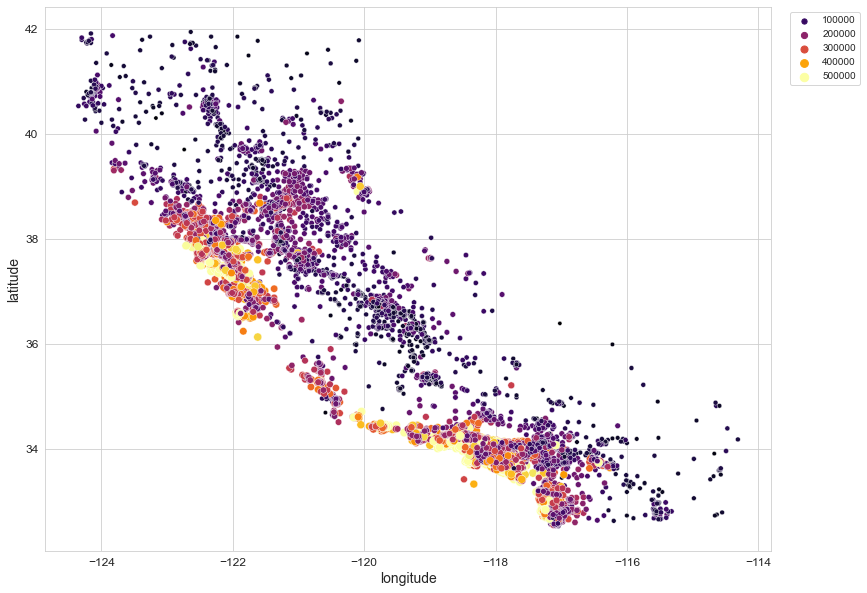

In [37]:
plt.subplots(figsize = (13,10))
g = sns.scatterplot(data = housing, x ='longitude', y = 'latitude',
    hue = 'median_house_value', palette='inferno',
    size='median_house_value'); 
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')


Let's make a slightly better looking plot..

Saving figure housing_prices_scatterplot


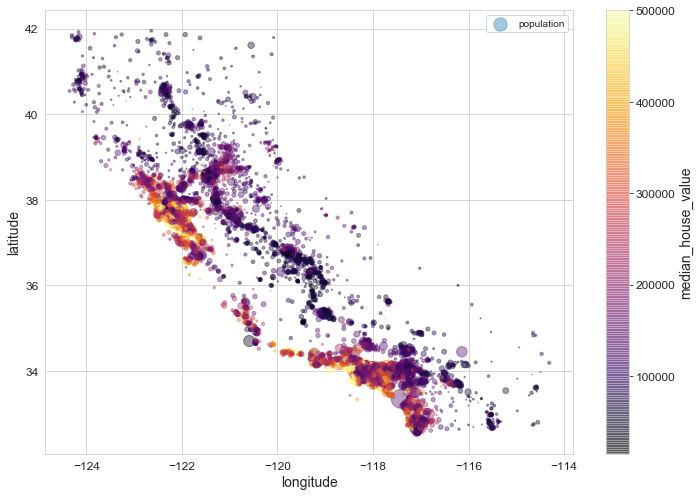

In [146]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap('inferno'), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

This image clearly shows that a house prices is related to location, as expected. For example, those houses near the ocean compared to those inland. We could use a clustering algorithm for detecting main clusters and for adding new features that measure proximity to these clusters. Prolixity to the ocean may not transfer to other regions.

### Download the California image

In [42]:
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/kevinprinsloo/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('C:/Users/kevin/OneDrive/Upskill_Puthon_DS/Github_oneDrive/End_to_end_ML_project/images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x272af98d550>)

C:\Users\kevin\AppData\Local\Temp\ipykernel_5332\898654004.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(ticks=tick_values/prices.max())


Saving figure california_housing_prices_plot


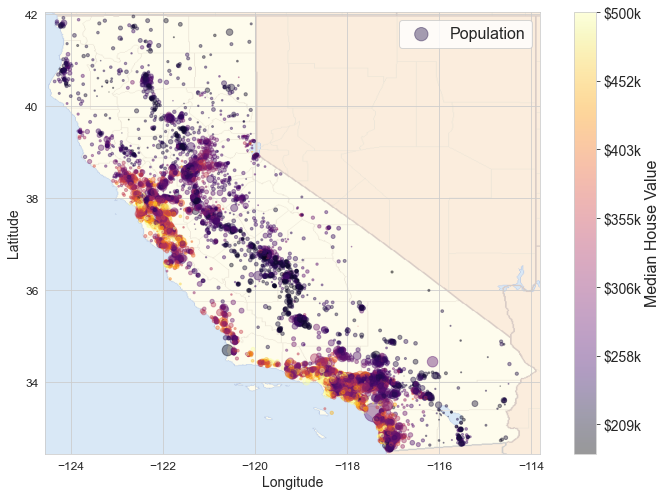

In [44]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap('inferno'),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.4,
           cmap=plt.get_cmap('inferno'))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

## Explore correlations in DataFrame

Our dataset is not very large so we can compuet the correlation between everypair of attributes using the `corr()` function

In [151]:
corr_matrix = housing.corr()

In [152]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Another way to explore these relationships is to use Pandas `scatter_matrix()` function, which plots every numerical attribute against each other. We have  11<sup>2</sup> = 121 plots. Obviously this is too many to explore here, so we will concentrate on the most promising attributes that seem most correlated with the `median_house_value`

In [31]:
attributes = ['median_house_value', 'median_income','total_rooms','housing_median_age']

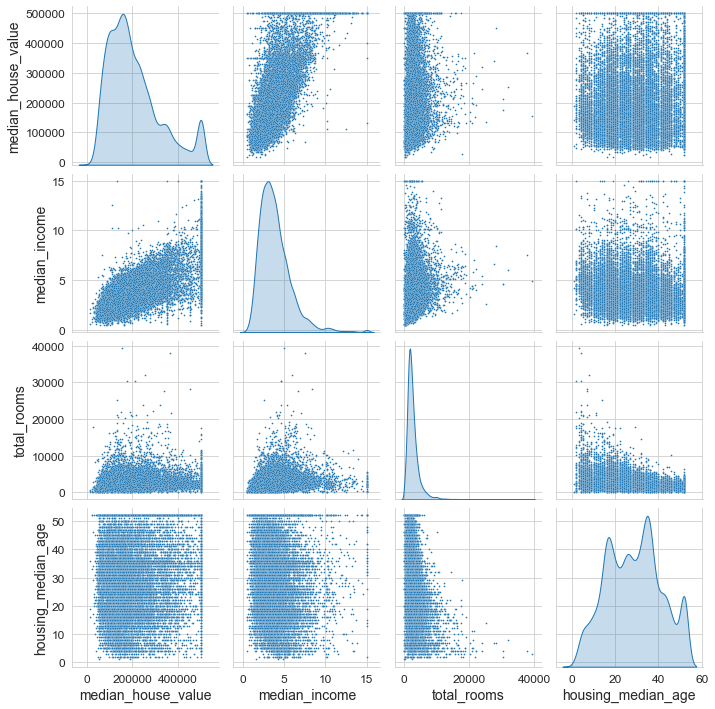

In [53]:
# Relationship between features
g = sns.pairplot(housing[attributes], diag_kind='kde',plot_kws={"s": 3})
save_fig("scatter_matrix_plot")

It seems that the attribute which is most likely to predict median house value is the median income, let's look at this data specifically

In [32]:
import scipy.stats as stats

Saving figure income_vs_house_value_scatterplot


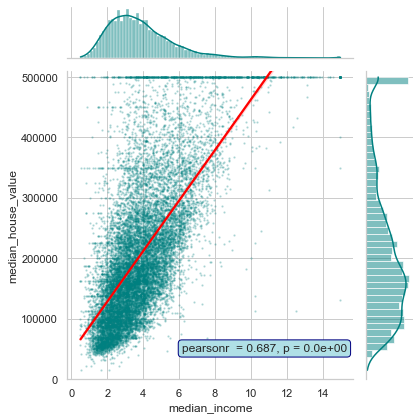

In [114]:
sns.set(style="whitegrid", color_codes=True)
g = sns.jointplot(x='median_income', y='median_house_value', data=housing, kind='reg', color='teal',
                line_kws={'color': 'red'}, scatter_kws={'s':2, 'alpha':0.2})

r, p = stats.pearsonr(housing['median_income'], housing['median_house_value'])

g.ax_joint.annotate('pearsonr 'f' = {r:.3f}, p = {p:.1e}',
                    xy=(0.4, 0.1), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
plt.axis([0, 960, 0, 510000])

save_fig("income_vs_house_value_scatterplot")

This plot shows us a few things:

* The data reveals a strong correlation (*rho* = 0.69, *p-value* < 0.001)
* We can see that the price cap discussed earlier is visible as a horizontal line at $500,000.
* However, this plot also reveals less obvious straight lines: seen at approx. $450,000, and another at $350,00, and with careful consideration perhaps one around $280,000, and slightly more clearly another around $80,000 

We might want to consider **removing these corresponding districts** from the to prevent the ML algorithm from learning to reproduce the these quirks in the data.

## Next we can experiment with attribute combinations

In the previous sections we rather briefly looked at possibly ways to explore the data and gain some insight from these. We can identify a few quirks in the data that we may want to clean-up before feeding the data into a Machine Learning (ML) algorithm. We also found some interesting correlations between various attributes. Most noteworthy of these was our attribute of interest `median_house_value`. We also noticed that some attributes have skewed distributions, we moving forward we may want to transform these data (e.g., by computing their `logarithm`). It's important to note that these steps are very much data-driven and varies with each project.


Finally, before preparing the data for ML algorithms is to try out various attribute combinations. For example, total number of bedrooms in a district is not very useful unless you know how many households there are. What is more informative is number of rooms per household (i.e, `rooms_per_household`). Likewise, the number of bedrooms on it's own is not very useful unless you compare that with the number of rooms (i.e, `bedrooms_per_household`). And the populations per household (i.e, `population_per_household`) also seems like an interesting factor:

In [33]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [34]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Plot some data..

(0.0, 960.0, 0.0, 520000.0)

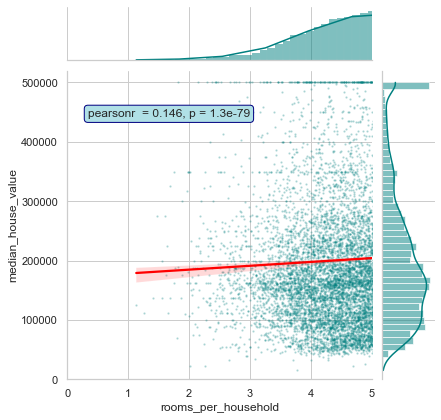

In [130]:
sns.set(style="whitegrid", color_codes=True)
g = sns.jointplot(x='rooms_per_household', y='median_house_value', data=housing, kind='reg', color='teal',
                line_kws={'color': 'red'}, scatter_kws={'s':2, 'alpha':0.2})

r, p = stats.pearsonr(housing['rooms_per_household'], housing['median_house_value'])

g.ax_joint.annotate('pearsonr 'f' = {r:.3f}, p = {p:.1e}',
                    xy=(0.6, 0.86), xycoords='axes fraction',
                    ha='right', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.axis([0, 5, 0, 520000])
plt.axis([0, 960, 0, 520000])

In [125]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


In [149]:
housing.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
longitude,1,-0.924478,-0.105848,0.048871,0.0765985,0.10803,0.0630696,-0.0195833
latitude,-0.924478,1,0.0057661,-0.0391837,-0.0724189,-0.115222,-0.077647,-0.0752054
housing_median_age,-0.105848,0.0057661,1,-0.364509,-0.325047,-0.29871,-0.306428,-0.11136
total_rooms,0.048871,-0.0391837,-0.364509,1,0.929379,0.855109,0.918392,0.200087
total_bedrooms,0.0765985,-0.0724189,-0.325047,0.929379,1,0.87632,0.98017,-0.00973978
population,0.10803,-0.115222,-0.29871,0.855109,0.87632,1,0.904637,0.00238001
households,0.0630696,-0.077647,-0.306428,0.918392,0.98017,0.904637,1,0.0107813
median_income,-0.0195833,-0.0752054,-0.11136,0.200087,-0.00973978,0.00238001,0.0107813,1


In [153]:
def correlation_heatmap(df):
    """arguments: data_frame:pandas DataFrame
       returns: correlation heatmap"""
    
    #  setting the context
    sns.set(context='paper', font='moonspace')
    
    #  making correlation object and saving it into variable
    correlation = df.corr()
    
    #  creating heatmap figure object (paper) and ax object (the plot)
    fig, ax = plt.subplots(figsize=(12, 8))
    
    #  generating color palettes
    cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
    
    #  draw the heatmap
    heatmap = sns.heatmap(correlation, vmax=1,vmin=-1,center=0, square=False, annot=True, cmap=cmap,
                         lw=2, cbar=False)
    
    return heatmap

findfont: Font family ['moonspace'] not found. Falling back to DejaVu Sans.
findfont: Font family ['moonspace'] not found. Falling back to DejaVu Sans.


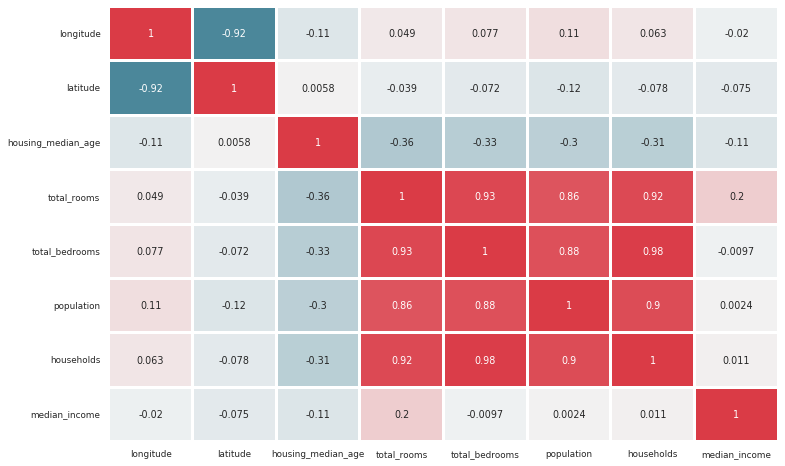

In [154]:
correlation_heatmap(housing);

Let us create few more attributes 

In [163]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

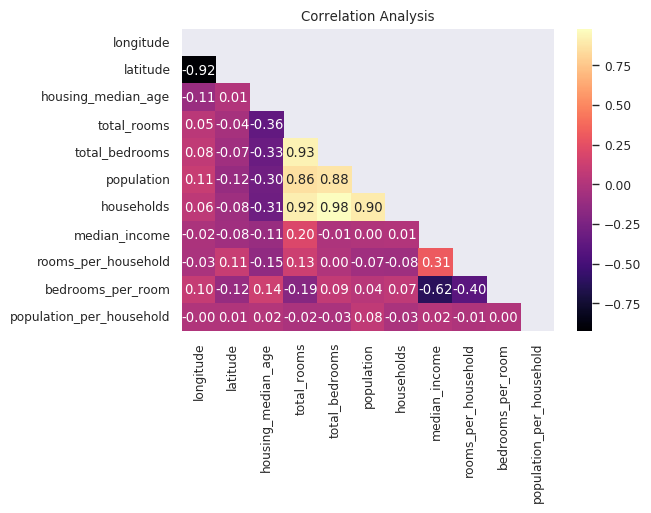

In [175]:
corr = housing.corr()
mask = np.triu(np.ones_like(corr,dtype = bool))

plt.figure(dpi=100)
plt.title('Correlation Analysis')
sns.heatmap(corr,mask=mask,annot=True,lw=0,linecolor='white',cmap='magma',fmt = "0.2f")
plt.xticks(rotation=90)
plt.yticks(rotation = 0)
plt.show()

# Prepare the data for Machine Learning algorithms

Right, now we get to the juicy bit, preparing the data for the ML model. Advice given is rather then doing this manually, one might want to write functions for this purpose. Several reasons are listed below:

* This enables you to easily reproduce these transformations on any dataset (i.e., when you get additional data)
* You will gradually start to build a library of transformation functions that you can resume on other projects in the future
* You can use these functions in your live system to transform the new data before feeding it to your algorithms
* This will make it possible for you to easily try various transformations and see which combinations of transformations works best.

Right, to begin with we'll start by using a clean training set (by copying `strat_train_set` once again). We'll also separate the predictors and the labels, since we don't necessarily want to apply the same transformations to the predictors and the target labels (note that `drop()` creates a copy of the data and does not affect `strat_train_set`):

In [35]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

We can make a quick plot to see missing values, below we can see we only have missing values for `total_bedrooms`

Text(66.5, 0.5, 'Sample Number')

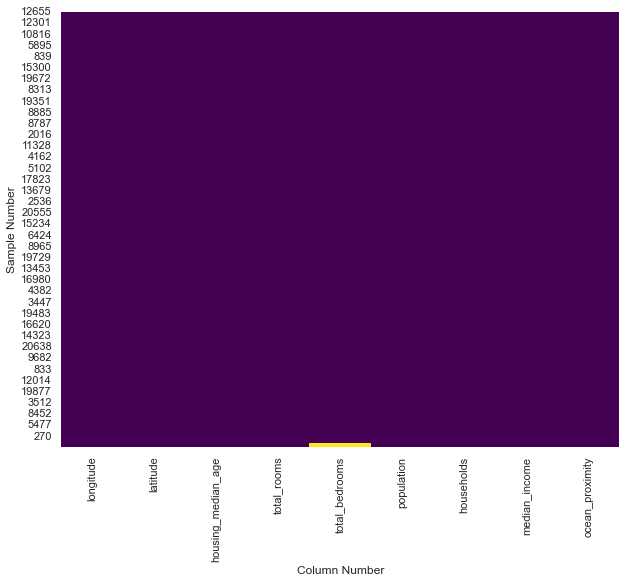

In [134]:
plt.figure(figsize=(10, 8))
sns.set_style('whitegrid')

# g = sns.heatmap(housing.isnull(), cbar=False, cmap='viridis')
g = sns.heatmap(housing.loc[housing.isnull().sum(1).sort_values(ascending=1).index].isnull(), cbar=False, cmap='viridis')
g.set_xlabel('Column Number')
g.set_ylabel('Sample Number')

The majority fo ML algorithms cannot deal with missing features, so let's create a few functions to take care of them. Earlier on we noticed that `total_bedrooms` attribute had some missing values, let's fix this. To this end, we have three options:

1. Remove the corresponding districts 
2. Remove the whole attribute
3. Interpolate the missing value with some other value (i.e., median, mean, zeros ...)

To do this we can use `dropna()`,`drop()`,`fillna()` methods on a DataFrame variable:

In [ ]:
housing.dropna(subset=['total_bedrooms'])    # >> option 1
housing.drop('total_bedrooms', axis=)        # >> option 2
median = housing['total_bedrooms'].median()  # >> option 1
housing['total_bedrooms'].fillna(median, inplace=TRUE)

If you choose **option 3** it's advised to compute the median on the **traning set** and use this to interpolate the missing values in this set using the median value. It's important to save the median value computed here so you can use it later to replace the missing values in the **test set** when we want to evaluate our system, and also once the system goes live to replace missing values in the new data.

In [36]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [136]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [137]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [37]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

In [38]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


Scikit-Learn provides some functionality to deal with missing values: `SimpleImputer`. Below outlines how to use it.

* First, you need to create a `SimpleImputer` instance, specifying that you want to replace each attribute's missing values with the median of that attribute.

In [39]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

Let's double check how many non-numerical attributes we have in our DataFrame

In [40]:
# Extract descriptive properties of non-numerical features
housing.describe(exclude=['number'])

,ocean_proximity
count,16512
unique,5
top,<1H OCEAN
freq,7276


Remove the text attribute because median can only be calculated on numerical attributes, here we create a copy of the data without non-numerical (i.e., text) attributes, and above we saw that is was only `ocean_proximity`:

In [41]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

Now we can fit the `imputer` instance to the training data using `fit()` method

In [43]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

The `imputer` has simply computed the median of each attribute and stored the results in the results in `statistics_` instance variable. Again as we saw above only `total_bedrooms` attribute had missing values, however, it's important to remember that we can't be sure that any new data that will be added won't have any missing values when the system goes live, so it's optimal to apply the `imputer` to all the numerical attributes:

In [44]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Check that this is the same as manually computing the median of each attribute:

In [47]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now we can use this "trained" `imputer` to transform the training set by replacing all the missing values with the learned medians

In [48]:
X = imputer.transform(housing_num)

The result is a Numpy array containing these transformed features, we can now put this back into the DataFrame using Pandas:

In [49]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing.index)

In [50]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [51]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


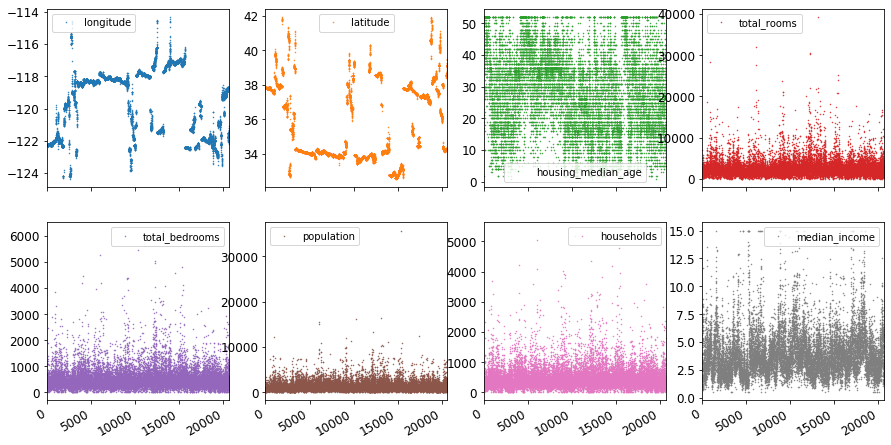

In [57]:
housing_tr.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 8), markersize=1);

## Non-numerical Feature and Categorical Attribute Handling

After dealing with the numerical features, we move on to categorical and non-numerical features (i.e., test and dummy-coding variables). As mentioned previously, there is only one text attribute: `ocean_proximity`.

In [102]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [110]:
housing_cat['ocean_proximity'].unique()

array(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'],
      dtype=object)

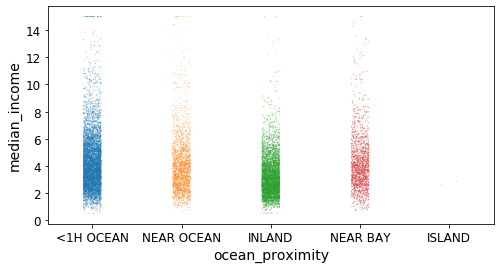

In [105]:
plt.figure(figsize=(8, 4))
sns.stripplot(data=housing, x=housing['ocean_proximity'], y=housing['median_income'], palette="tab10", size=1, alpha=0.5)

[]

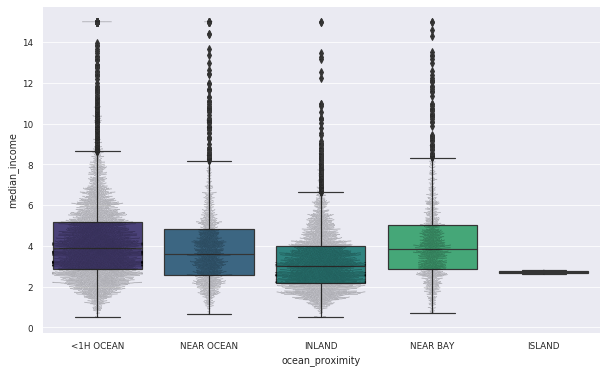

In [161]:
#boxplot of house value on ocean_proximity categories
plt.figure(figsize=(10,6))
sns.boxplot(data=housing, x='ocean_proximity', y='median_income', palette='viridis')
sns.swarmplot(data=housing, x='ocean_proximity',y='median_income',color = 'black', size = 1, alpha = 0.3)
plt.plot()

As we can see in the plot above the text is not arbitrary but rather it indexes categorical features for location. ML models prefer to work with numerical features rather  than categorical text features. So here we will convert these categories to numerical features (i.e., dummy-coding). for this we use **SciKit-Learn'S** `OrdinalEncoder` class.

In [108]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

We can get a list of categories using 'categories_' instance variable. Here we only have 1 categorical varibale so we get a 1D array:

In [114]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms assume that two nearby values are more similar than two distant values. In some cases this would make sense, for example, ordinal data such as: "bad","average","good","excellent", but in the current data we can see this is clearly not the case. Looking at `ocean_proximity` we can see for example, that category 0 and 1 are more similar than category 0 and 4. 

To this end, one common solution is to create one binary attribute per category: one attribute equal to **1** when the category is **"<1H Ocean"** (and others are all set to 0), and one attribute equal to **1** when the category is **"<INALND"** (and others are set to 0), and so on. This is called ***one-hot encoding***, because only one feature can be equal to 1 (**hot**), while the others will be 0 (**cold**). These new attributes are sometimes called ***dummy*** variables. Scikit-Learn provides `OneHotEncoder` class to convert to categorical values into **one-hot vectors**

In [115]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [116]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [117]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

It's worth noticing that the output is a SciPy ***sparse matrix***, instead of a Numpy array. This means that rather than having a large matrix of zeros containing only a single **1** for each row would use loads of memory, instead here the ***hot encoder*** i.e., the non-zero element index locations is stored (i.e., ***sparse matrix***). Largely you can use it like you would a 2D matrix, but if you want to convert it to a (dense) Numpy array, just call `toarray()` method: `housing_cat_1hot.toarray()`

In [119]:
# Here we can get a list of the categories again..
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

### Custom Transformers

Although SciKit-Learn provides many useful transformers, here we create our won for tasks such as custom cleanup operations or combining specific attributes. SciKit-Learn relies on **non-inheritance** and we want to ensure our transformer works within a pipeline, what we do is create a class and implement three methods: `fit()` (returning self), `transform()` and `fit_transform()`.

In [121]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

One method to do this is with the following code below. Although there is a slightly updated way of doing it further down.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Below is a more user friendly way to use the `FunctionTransformer` class provided by SciKit-Learn

Alternatively, you can use Scikit-Learn's `FunctionTransformer` class that lets you easily create a transformer based on a transformation function (thanks to [Hanmin Qin](https://github.com/qinhanmin2014) for suggesting this code). Note that we need to set `validate=False` because the data contains non-float values (`validate` will default to `False` in Scikit-Learn 0.22).

In [123]:
from sklearn.preprocessing import FunctionTransformer

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [124]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In the examples above the transformer has one **hyperparamter** `add_bedrooms_per_room`, which is set to `True` by default. **Hyperparamters** will enable you to test whether an attribute is contributing to the ML model or not.

## Feature Scalling

For optimal performance, ML algorithms require you to conduct ***feature scaling***. It's absolutely necessary for some models. Two common way to do this is:

* **Normalization** - rescales all data values between 0-1. Using `MinMaxScaler`
* **Standardization** - rescales data to have mean ( &mu; ) of 0 and standard deviation  (&sigma;) of 1. Using `StandardScaler` (zscore).

In the current dataset, housing data: total rooms range from about 6 to 39,320 while the median income only ranges from 0 to 15.

Now let's build a pipeline for preprocessing the numerical attributes (note that we could use `CombinedAttributesAdder()` instead of `FunctionTransformer(...)` if we preferred):

**Note**: Imputer is now called SimpleImputer from sklearn

### Transformation Pipelines

SciKit-Learn provides a helpful `Pipeline` class to ensure the correct sequence of transformation steps are executed in the correct order. Below is a small pipeline for the numerical attributes:

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

# Using the pipline on only the numerical columns
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [126]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

The `Pipeline` constructor takes in a list of estimator pairs defining a sequence of steps. Note all but the last must be a transformer (i.e., each must have a `fit_transform()` method). The names can be anything you'd like, but ensure they are unique and don't contain double underscores `__`.

Why use `FunctionTransformer`

* Move all pre-processing steps from Numpy and Pandas to SciKit-Learn. For example, if you were using `git dummies` in Pandas, you would use `one hot encoder` is SciKit-Learn instead. If you were using imputation in Pandas you would use one of the imputers in SciKit-Lear etc.
* But if you need to use a custom transformation to pre-process your data before using it for ML, and that's not natively available in SciKit-Learn, you can use `FunctionTransformer` instead.
* To do this we take a **Function** and convert it to a **Transformer** because SciKit-Learn works with specific types of objects and there are **estimator objects** which are usually models, and there are transformer objects which do transformations.
* To this end, we make our **Function** which is not available in SciKit-Learn, available in SciKit-Learn by converting the **function** to a **Transformer** object.
And this is what function **Transformer** does.

In addition to simply wrapping a given user-defined function, the `FunctionTransformer` provides some standard methods of other sklearn estimators (e.g., `fit()` and `transform()`). The benefit of this is that you can introduce arbitrary, stateless transforms into an sklearn Pipeline, which combines multiple processing stages. This makes executing a processing pipeline easier because you can simply pass your data (X) to the `fit()` and `transform()` methods of the Pipeline object without having to explicitly apply each stage of the pipeline individually.

One great advantage of using `FunctionTransformer` is that is makes it easier to apply the same pre-processing to new data that you are going to make predictions for

**Warning**: earlier versions of the handson ml book applied different transformations to different columns using a solution based on a `DataFrameSelector` transformer and a `FeatureUnion` (see below). It is now preferable to use the `ColumnTransformer` class that was introduced in Scikit-Learn 0.20. If you are using an older version of Scikit-Learn, you can import it from `future_encoders.py`:


In [128]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

Until now, we've handled the categorical columns and numerical columns separately. However, it would be more convenient to have a single transformer applied to each each appropriate column. To do this we use `ColumnTransformer` and this works well with Pandas.

* The `ColumnTransformer` class requires a list of tuples containing a name, a transformer, and a list of names (or indices) of columns that the transformer should be applied to.
* Here we specify that the numerical columns should be transformed using the `num_pipeline` that we defined earlier, and the categorical columns should be transformed using the `oneHotEncoder`.
* Finally, we apply the `ColumnTransformer` to the housing data. Thi8s applies each transformer to the appropriate columns and concatenates the output along the second axis (transformers must return the same number of rows).

In [129]:
num_attribs = list(housing_num) # numerical columns only, we dropped 'ocean_proximity' above
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [130]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [131]:
housing_prepared.shape

(16512, 16)

**That's it, we have now preprocessed all our data and applied the appropriate transformations.**

# Select and train a model 

At this stage we have done all the ground work to put us on the best foot forward to running some models.

* We have framed the problem
* Explored the dataset
* Sampled a training set
* Wrote transformation pipelines to clean up and prep data for ML automatically

We are now ready to select and train a Machine Learning model

Let's train a **Linear Regression** model

In [134]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's try out a few instances from the training set

In [135]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Compare against the actual values:

In [136]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


The model works, although looking at the first prediction, the accuracy is off by about 40%. Next, let's measure this regression model's **RMSE** on the whole training set using Scikit-Learn's `mean_squared_error()` function:

In [137]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [138]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

This result is somewhat alright, but the score is not great. As we've seen most median house prices range from $120,000 - $265,000, so a prediction value of $68,628 is clearly far off the mark. This results is a good indication that the model is underfitting the data. Once possible explanation for this is that the features do not provide enough information to make a decent prediction. It could also mean the model is not powerful enough or too simplistic.

Once way to deal with this is to consider using a more powerful model, with which we can feed into the Ml algorithm with better features, or we could reduce the constraints on the model. However, this model is not regularized, so that rules out the last option. We could try to add more features (e.g., the lof of the population).

But first, let's try a more complex model - `DecisionTreeRegressor`. This powerful model is capable of predicting complex non-linear relationships in the data (Decision Trees)

In [166]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Now that we have trained the model, let's evaluate it on the training set.

In [167]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

***ALL HANDS ON DECK***... so this results indicated that we have zero error in our model. Now this is unlikely to be the case, but rather an indication that we have overfit the model. ML best practice states that we should not touch the test set until we are ready to launch your model. So the best next step would be to split your training set data and evaluate the model on that. To do this we use **Cross-Validation**

### Improved Model Evaluation Using Cross-Validation

One methods used to evaluate a Decision Tree model would be to use `train_test_split()` to split the training set into a smaller training set and validation set, then train your model on the smaller training sub-set. 

Another, great alternative is to use SciKit-Learn's *K-fold cross validation*. The data is randomly split into 10 distinct *folds*, then it trains and evaluates the model (Decision Tree) 10 times, in a ***leave-one-out*** method, so picking a different *fold* for evaluation every time and training on the other 9 folders. The result is an array containing the 10 evaluation scores:

### Fine-tune your model

In [142]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

>> SciKit-Learn's cross-validation feature expects a utility function (a larger value metric is better) rather than a cost function (lower the metric value better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes `-scores` before calculating the square root.

> Scoring Options: https://scikit-learn.org/stable/modules/model_evaluation.htm 

In [199]:
from sklearn.model_selection import cross_validate

scores_more = cross_validate(tree_reg, housing_prepared, housing_labels,
                         scoring=['neg_mean_absolute_error','neg_mean_squared_error','max_error'],cv=10)
pd.DataFrame(scores_more)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_max_error
0,0.275263,0.002993,-43082.665860,-4.634050e+09,-408800.0
1,0.311158,0.002991,-44017.415254,-4.477433e+09,-440001.0
2,0.313164,0.001996,-44677.322229,-5.120455e+09,-391701.0
3,0.269280,0.001997,-44143.163537,-4.739758e+09,-363000.0
4,0.279245,0.001995,-46074.239855,-5.253427e+09,-432501.0
5,0.459773,0.003987,-47836.087220,-5.716554e+09,-452501.0
6,0.501658,0.003990,-44696.890369,-5.055042e+09,-415000.0
7,0.357046,0.002991,-45226.997577,-5.085202e+09,-462501.0
8,0.277254,0.001995,-48773.938219,-5.936552e+09,-406201.0
9,0.231415,0.001994,-44286.172623,-4.881448e+09,-415000.0


In [200]:
pd.DataFrame(scores_more).mean()

fit_time                        3.275256e-01
score_time                      2.692938e-03
test_neg_mean_absolute_error   -4.528149e+04
test_neg_mean_squared_error    -5.089992e+09
test_max_error                 -4.187206e+05
dtype: float64

In [148]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


Based on these results we can see the Decision Tree performance reduced compared to our previous attempt (even performing worse than the Linear Regression). It's worth point out that cross validation not only give a metric that quantifies the performance of the model, but also provides a measure of how precise this estimate is (i.e., standard deviation &sigma;). The Decision Tree has a score of 71,407 with &#177; 2,439.

Let's compute the same scores for the Linear regression model..

In [165]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983434


Right so now we can confirm that the Decision Tree is overfitting the model, to the extend it is doing worse than the Linear Regression model.

Let's try **`RandomForestRegressor`**. Briefly, Random Forest regression works by training many Decision trees on random subsets of the features, then averaging out their predictions. This idea of building a model on top of many models is called ***Ensemble Learning*** and it's a great way of pushing ML algorithms further.

In [172]:
from sklearn.ensemble import RandomForestRegressor

#forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [173]:
# Traning set
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [176]:
# Validation set
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [183]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

The model performance is considerably better. **Random Forest** look very promising. However, the score om the training set is till much lower than the validation sets meaning the model is still overfitting the training set. Possibly solutions to this is to simplify the model (constrain it, i.e., regularize), or get a lot more training data. However, without spending too much time tweaking the hyperparameters in the Random Forest model, it might be a good idea to try a few other models out (e.g., SVM with different kernels, and possibly NNM).

In [184]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [ ]:
# Let's save out models for later
import joblib

joblib.dump(my_model, "my_model.pkl")
# and to load the model later...
my_model_loader - joblib.load("my_model.pkl")

### Fine Tune the Model - Grid Search

**hyperparameter tuning**
Now we can explore manipulation of the hyperparameter tuning automatically using Grid Search techniques `GridSearchCV`. By inputting the hyperparameters you would like to explore and with what values you want to maximize, and it will use cross-validation to evaluate the hyperparameter tuning.

For example the following code searches for the best combination of hyperparameter values from the `RandomForestRegressor`:

>> If you're unsure which values to use for the hyperparameters, one tip is to use powers of 10 or smaller numbers for fine-grained search. Or check the documentation in SciKit-Learn of what are good rangers are for the various hyperparameters of your model

In [196]:
from sklearn.model_selection import GridSearchCV

# Create a Dictonary
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

The `param_grid` informs SciKit-Learn to first evaluate all 3 x 4 = 12 combinations of `n_estimators` and `max_features` hyperparameter values specified in the the first `dict`, then try 2 x 3 = 12 combinations of `n_estimators` and `max_features` but this time with `bootstrap` hyperparameter values in the second `dict`. The grid search will explore 12 + 6 = 18 combinations of `RandomForestRegressor` hyperparameter values, and will train the model 5 times (i.e., we are using 5 fold cross validation). In total that is 18 x 5 = 90 round of training!

The best hyperparameter combination found:

In [197]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [213]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [214]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In this example, we can see that the best solution ***49682.273345071546 {'max_features': 8, 'n_estimators': 30}*** is by setting the `max_features` hyperparameter to **8** and the `n_estimators` hyperparameter to **30**. The **RMSE** score for this combination is 49,682, which is slightly better than the score we got earlier using the default hyperparameter value (which was 50,128).

**We did it, we have fine-tunes the best model!**

In [215]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.209795,0.018592,0.012366,0.003738,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.694172,0.124022,0.026612,0.003911,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,1.331133,0.295259,0.047191,0.004923,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.167135,0.010917,0.005434,0.000474,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.629362,0.113734,0.016877,0.003505,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.748747,0.194679,0.042953,0.004693,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.212624,0.013980,0.005080,0.000179,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.741789,0.119085,0.016065,0.001767,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,2.510172,0.503618,0.043314,0.006921,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.334460,0.021337,0.007063,0.000676,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


### Random Search

Using grid search works well when exploring relatively few combinations, like in the previous example, when when the hyperparameter search space is large it's far more optimal to use `RandomizedSearchCV`. This class is used somewhat the same as `GridSearchCV` but instead of trying our all combinations, it evaluates a given number of random combinations.

There are two main benefits:
1.  Is you select 1000 iterations for example, it will explore 1000 different values for each hyperparameter instead of just a few per hyperparameter with the grid search approach.
2. Simply by setting the number of iterations, you have more control over the computing resources you want to allocate to hyperparameter search.

In [216]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [217]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


best model: ***49150.70756927707 {'max_features': 7, 'n_estimators': 180}***

## Ensemble Methods

Another way to fine tune the model is to tyr a combinations of models that perform the best. The group/ensemble will often perform better than the best individual model. Much like the theory of how Random Forests perform better than the Decision Trees they rely on.

### Analyse the best models and thier errors


In [218]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

Let's display these importance scores next to their corresponding attribute names:

In [219]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

These results show that you might want to drop less useful features, for example, it seems only one `ocean_proximity` feature is useful. We should also look at the errors the system makes and try to understand why it makes these. Then attempt to fix them (i.e., adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.).

## Finally let's evaluate our model on the test set

Now that we have tweaked the model and it works sufficiently well, we can now evaluate the final model on th test set.

In [220]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [221]:
final_rmse

47730.22690385927

We can compute a 95% confidence interval for the test RMSE:

In [222]:
from scipy import stats

In [223]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

We could compute the interval manually like this:

In [224]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776014, 49691.25001877871)

Alternatively, we could use a z-scores rather than t-scores:

In [225]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136594, 49690.68623889426)

Thank you for reading my tutorial on an example ML project. 

If you liked this article, be sure to show your support by clapping for this article below and feel free to leave a comment I’d love to hear from you, even if it's to point out an error or help me improve.

You can also find me [Twitter](https://twitter.com/KevinD_P)